# Image deconvolution

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
plt.rc("text", usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
from tramp.models import MultiLayerModel
from tramp.variables import SIMOVariable, MILeafVariable, SISOVariable as V, SILeafVariable as O
from tramp.channels import Blur2DChannel, GaussianChannel, GradientChannel
from tramp.priors import BinaryPrior, GaussianPrior, GaussBernouilliPrior
from tramp.experiments import TeacherStudentScenario

In [3]:
def plot_data(x_true, y, x_pred):
    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].imshow(x_true["x"], cmap="gray")
    axs[0].set(title=r"x true")
    axs[1].imshow(y, cmap="gray")
    axs[1].set(title=r"y")
    axs[2].imshow(x_pred["x"], cmap="gray")
    axs[2].set(title="x pred")
    fig.tight_layout()
    
def compare_hcut(x_true, x_pred, h):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=False)
    axs[0].plot(x_true["x"][:,h], label="true")
    axs[0].plot(x_pred["x"][:,h], label="pred")
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_true["z"][:,h], label="true")
    axs[1].plot(x_pred["z"][:,h], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()

## Teacher

In [4]:
from tramp.priors.base_prior import Prior

def square_blob(shape, x0, x1, y0, y1):
    g = np.zeros(shape)
    g[x0:x1, y0:y1] = 1.
    return g

class BlobPrior(Prior):
    def __init__(self, size, corners):
        self.size = size
        self.corners = corners
    def math(self):
        return "blob"
    def sample(self):
        X = sum(
            square_blob(self.size, x0, x1, y0, y1)
            for x0, x1, y0, y1 in self.corners
        )
        X = 2*X - 1
        return X

In [5]:
x_shape = (40,50)
blob = BlobPrior(x_shape, corners=[
    (5, 10, 5, 15), (5, 15, 20, 40), (20, 35, 15, 45),  
])

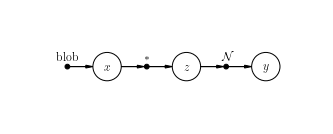

In [6]:
blur = Blur2DChannel(shape=x_shape, sigma=[3, 3])
noise = GaussianChannel(var=0.1)
teacher = MultiLayerModel([blob, blur, noise], ids=["x", "z", "y"])
teacher.plot()

In [7]:
# empirical estimate of hyperparameters
sample = teacher.sample()
p_pos = (sample["x"]>0).mean()
print(f"p_pos = {p_pos}")

p_pos = 0.35


## Binary image denoising

Student only use x binary as prior information.

In [8]:
prior = BinaryPrior(x_shape, p_pos=p_pos)
student = MultiLayerModel([prior, blur, noise], ids=["x", "z", "y"])

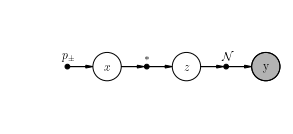

In [9]:
scenario = TeacherStudentScenario(teacher, student, x_ids=["x", "z"])
scenario.setup(seed=1)
scenario.student.plot()

In [10]:
_ = scenario.run_ep(max_iter=100, damping=0)

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:no damping
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-06
INFO:tramp.algos.message_passing:terminated after n_iter=15 iterations


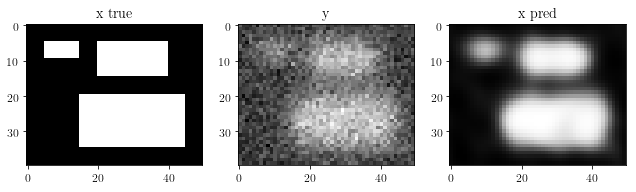

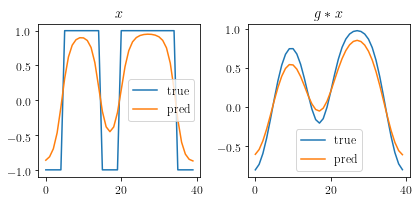

In [11]:
plot_data(scenario.x_true, scenario.observations["y"], scenario.x_pred)
compare_hcut(scenario.x_true, scenario.x_pred, h=25)